In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point
%matplotlib inline
from shapely.ops import cascaded_union
from geopandas import GeoSeries #вообще нахер не нужный мусор, засоряющий память
import pyproj # для конвертации координат в плоскость, хотя тут нужно уточнить
import math #эта шляпа нужна для синусов / косинусов и углов
import descartes #хз зачем это
from pylab import cm #это ещё чт за говно

# Создание сетки

Здесь куча джигурды-пояснений

#### Типа задаем параметры

In [91]:
# Директория с данными сетки
grid_data_dir = 'BatyaGritMalatsa/'

# Имя полигона города, который хранится в 
city_polygon = 'batyas_place2.geojson'

# Задаем длину квадрата
width = 500

# Собсна загружаем полигон

In [92]:
#Здесь в работу вступает модуль pyproj.Proj и я ес чесн хз что он делает
# wgs84 -- 3D sphere model of Earth, читал про неё на днях. Типа это стандарт, по которому работает GPS
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth -- хорошо, а как насчёт яндекса?
pm = pyproj.Proj("+init=EPSG:32646") # Для КРСКа выбираем спец UTM зону - хмммммммм

In [93]:
#ну грузим полигон, чо
with open(grid_data_dir + city_polygon, encoding = 'utf-8') as k:
    krsk_file = json.load(k) #выглядит как словарь

In [94]:
krsk_file

{'type': 'FeatureCollection',
 'metadata': {'name': 'Без названия', 'creator': 'Yandex Map Constructor'},
 'features': [{'type': 'Feature',
   'id': 0,
   'geometry': {'type': 'Polygon',
    'coordinates': [[[92.818280420654, 55.99686289191914],
      [92.85398598706024, 56.006097172116775],
      [92.8993045905759, 56.012636779988604],
      [92.90205117260714, 56.02417455285036],
      [92.92539711987278, 56.03071108773877],
      [92.9343235114743, 56.03801531162784],
      [92.97346230541963, 56.04454949328903],
      [92.9947483161618, 56.054156565597694],
      [93.00642128979462, 56.0733635029933],
      [92.9370700935056, 56.08948990571171],
      [92.78600808178685, 56.04224343840255],
      [92.818280420654, 55.99686289191914]]]},
   'properties': {'description': 'Левый берег',
    'fill': '#ed4543',
    'fill-opacity': 0.6,
    'stroke': '#ed4543',
    'stroke-width': '5',
    'stroke-opacity': 0.9}},
  {'type': 'Feature',
   'id': 1,
   'geometry': {'type': 'Polygon',
    '

In [95]:
len(krsk_file['features'])

3

In [96]:
krsk_file['features'][0]['geometry']['coordinates'][0]

[[92.818280420654, 55.99686289191914],
 [92.85398598706024, 56.006097172116775],
 [92.8993045905759, 56.012636779988604],
 [92.90205117260714, 56.02417455285036],
 [92.92539711987278, 56.03071108773877],
 [92.9343235114743, 56.03801531162784],
 [92.97346230541963, 56.04454949328903],
 [92.9947483161618, 56.054156565597694],
 [93.00642128979462, 56.0733635029933],
 [92.9370700935056, 56.08948990571171],
 [92.78600808178685, 56.04224343840255],
 [92.818280420654, 55.99686289191914]]

In [97]:
#Дальше идёт объединение полигонов, но надо ли мне их объединять? Сделаем это по приколу
#####Дальше конвертация из объемных в плоские координаты
gathering_into_union = []
for part in range(len(krsk_file['features'])):
    # Грузим все части Красноярска, хотя там всего одна ЛОЛ... Ну в первоначальном... Теперь вот три
    krsk_part = krsk_file['features'][part]['geometry']['coordinates'][0] #докапываемся до координат полигона
    # Transform to 2d coords and make polygons
    # x for lon and y for lat
    krsk_part_coords = []
    for i in range(len(krsk_part)):
        ####### input in format (lon, lat) - ну это и так понятно
        x, y = pyproj.transform(wgs84, pm, krsk_part[i][0], krsk_part[i][1]) #трансформируем гео координаты в x и y
        krsk_part_coords.append([x,y]) #добавляем
    krsk_part_polygon = Polygon(krsk_part_coords) #в игру вступает модуль shapely.geometry
    gathering_into_union.append(krsk_part_polygon) #таким образом получаем лист полигонов... Вроде как даже захешированных
# Собираем все части Красноярска в один полигон... а зачем?
krsk = cascaded_union(gathering_into_union) #из нескольких полигонов в листе собирается 1, функция берется из shapely.ops

#Сейчас данные сконвертированы из объемных координат в плоские

In [98]:
#чтоб не забывал, что такое krsk
type(krsk)

shapely.geometry.multipolygon.MultiPolygon

## АЗАЗАЗАЗА ЗАГРУЖАЕМ МЕТКИ

In [99]:
marks = pd.read_csv(grid_data_dir + 'krsk_places.csv', sep=';')

In [100]:
marks

,Altitude,Longitude,Description,Mark,Number
0,56.049548,92.924574,"Гаражи, место сходки",Гаражи,NaN
1,56.047206,92.934326,"Корпус, место где провёл кучу времени",Корпус,NaN
2,56.054267,92.953200,"Старый двор, возле школки",Старый двор,NaN
3,56.050968,92.991911,Гандоновка))) Полуостров,Полуостров,NaN
4,56.037159,92.935072,Самый нормальный ТЦ,Июнь,NaN
5,56.024162,92.918869,Батин остров,Вотчина,NaN
6,55.967378,92.944103,Батин гараж,Бокс,NaN
7,55.994009,92.738689,"Ееее, место для шашлыка",Шашлык,NaN
8,56.014016,92.905179,Мимокрокодил всё время,Мост,NaN
9,56.019969,92.885218,Просто хороший вид,Вид,NaN


In [101]:
np.array((marks.loc[:, ['Longitude', 'Altitude']])).tolist()

[[92.92457399999999, 56.049548],
 [92.934326, 56.047206],
 [92.9532, 56.054267],
 [92.991911, 56.050968000000005],
 [92.93507199999999, 56.037158999999996],
 [92.918869, 56.024162],
 [92.944103, 55.967378000000004],
 [92.73868900000001, 55.994009],
 [92.905179, 56.014016000000005],
 [92.88521800000001, 56.019968999999996],
 [92.870174, 55.994141000000006]]

In [102]:
#krsk_places_2d
krsk_places_coord_list = np.array((marks.loc[:, ['Longitude', 'Altitude']])).tolist()
krsk_places_2d = []
krsk_places_2d_points = []
for i in range(len(krsk_places_coord_list)):
    x, y = pyproj.transform(wgs84, pm, krsk_places_coord_list[i][0], krsk_places_coord_list[i][1]) #трансформируем гео координаты в x и y
    krsk_places_2d.append([x,y]) #добавляем
    krsk_places_2d_points.append(Point(x,y))

In [103]:
krsk_places_2d

[[495301.8659530651, 6211596.732960331],
 [495909.050501277, 6211335.452269471],
 [497085.27768106293, 6212120.371639541],
 [499496.1708915833, 6211752.240713233],
 [495954.4691023623, 6210217.197018899],
 [494943.19480362744, 6208771.726704452],
 [496510.8905220434, 6202450.2671210375],
 [483700.10414736375, 6205443.618554321],
 [494088.36291300354, 6207643.587949813],
 [492844.99095088866, 6208308.029521974],
 [491901.81380414957, 6205435.102469838]]

In [130]:
type(krsk_places_2d_points[4])

shapely.geometry.point.Point

# Ну, считаем квадратную сетку

In [105]:
def calculate_grid(startx, starty, endx, endy, step):
    """
    Тут кароч Батя считает сетку. Вроде как логично: топаем слева направо, снизу вверх на известный шаг.
    Возвращает GeoDataFrame, каждая строка - полигон сетки (квадратик) 
    """
    #в оригинале здесь идёт куча шляпы,связанной с шестиугольниками, но я обойдусь без этого
    
    origx = startx #сохраняем оригиналы
    origy = starty
    
    polygons = [] #пустой список для хренения координат квадратов
    row = 1 #номер ряда
    #counter = 0 #счётчик - нахер не нужный, т.к. нигде не используется
    
    while starty < endy: # ...то есть всегда???
        startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty
            p2x = startx + step
            p2y = starty
            p3x = startx + step
            p3y = starty + step
            p4x = startx
            p4y = starty + step
            square_poligon = [ #мутим лист кортежей из координат, замкнутую фигуру. В нашем случае - квадрат
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p1x, p1y)]
            polygons.append(square_poligon)
            #counter += 1 # ну так и выброси его нахрен
            startx += step
        row += 1
        starty += step
        
    '''
    вообще, в этом блоке я добавляю линейное преобразование в виде умножения координат на ортогональную матрицу
    '''

    sth = [Polygon(polygons[i]) for i in range(len(polygons))] #какой то генератор. Polygon принимает на вход лист координат одного полигона и лепит полигон
    grid = gpd.GeoDataFrame({'geometry':sth}) #Прикольно, мы заворачиваем в геодатафрейм словарь с единсвтенным ключом
    
    return grid

In [106]:
# для размера сетки нужны стороны прямоугольника
minx, miny, maxx, maxy = krsk.bounds #Метод bounds вызывается от класса shapely.geometry.multipolygon.MultiPolygon

In [107]:
krsk.bounds #типа крайние точки полигона

(484403.27941038157, 6196273.140875499, 510514.779133858, 6216041.428746376)

#### Поехали, рисуем простую сетку

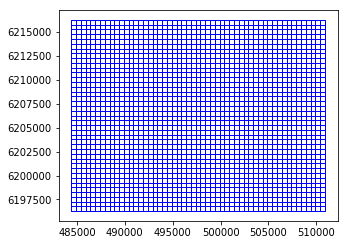

In [108]:
ordinary_grid = calculate_grid(minx, miny, maxx, maxy, width)
ordinary_grid.plot(color = 'white', edgecolor = 'blue', figsize = (5, 5)) #т.к. это геодатафрейм, то его можно нарисовать

In [109]:
#посмотри, что получилось
ordinary_grid.head(6)

,geometry
0,"POLYGON ((484403.2794103816 6196273.140875499,..."
1,"POLYGON ((484903.2794103816 6196273.140875499,..."
2,"POLYGON ((485403.2794103816 6196273.140875499,..."
3,"POLYGON ((485903.2794103816 6196273.140875499,..."
4,"POLYGON ((486403.2794103816 6196273.140875499,..."
5,"POLYGON ((486903.2794103816 6196273.140875499,..."


In [110]:
ordinary_grid.loc[0]

geometry    POLYGON ((484403.2794103816 6196273.140875499,...
Name: 0, dtype: object

#### Дальше самое веселое - сопоставляем исходный полигон с сеткой. На выходе сетка в форме города

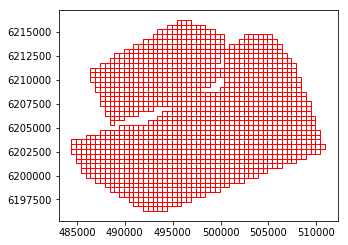

In [111]:
intersect_square = [] # список квадратов, которые получились в результате пересечения
for i in range(len(ordinary_grid)):
    #если пересечение границы города и сетки непустое, то включаем всю соту полностью - чегооооо????????
    if krsk.intersection(ordinary_grid.iloc[i][0]).area > 0.0: #метод от shapely.geometry.multipolygon.MultiPolygon
        intersect_square.append(ordinary_grid.iloc[i][0]) #ну то есть если непустой, то зааппедить
        
grid_intersect = gpd.GeoDataFrame({'geometry':intersect_square}) #снова формируем геодатафрейм
grid_intersect.plot(color='white', edgecolor='red', figsize=(5,5))
        

In [131]:
#grid_intersect.head()
#grid_intersect.iloc[1]
type(intersect_square[3])

shapely.geometry.polygon.Polygon

#### По приколу определим число квадратов

In [113]:
print(len(grid_intersect[grid_intersect['geometry'].notnull()]))
print(len(grid_intersect))

1358
1358


## Ну шо, теперь нужно наложить метки на сетку города

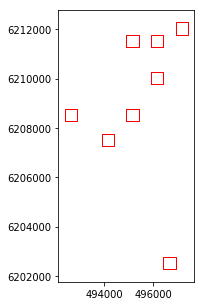

In [134]:
#здесь явно потребуется цикл
places_intersect = []
#для начала самый тупой алгоритм
for i in range(len(krsk_places_2d_points)):
    for j in range(len(grid_intersect)):
        if krsk_places_2d_points[i].within(intersect_square[j]): #здесь сопоставляются объекты библиотеки shapely
            places_intersect.append(grid_intersect.iloc[j][0]) #лучше заменить на множества, т.к. нам нужны уникальные
familiar_areas = gpd.GeoDataFrame({'geometry':places_intersect}) #снова формируем геодатафрейм
familiar_areas.plot(color='white', edgecolor='red', figsize=(5,5))

### И самое последнее - жопа - конвертация нашего 2d в 3d

In [136]:
#сперва напишем трансформирующую функцию, которая возвращает список
def transform_to_3d (grid):
    """
    grid - в данном случае полигоны сетки в виде GeoDataFrame
    proj3d_pols - список спроецированных в 3D полигонов сетки
    """
    proj3d_pols = []
    for i in range(len(grid)):
        try:
            xp, yp = grid.iloc[i][0].exterior.coords.xy #это ещё что такое?????????
            xp, yp = list(xp), list(yp) #трансформация верхних значений... в листы?
            x, y = pyproj.transform(pm, wgs84, xp, yp) #собсна вот наша трансформация из 2d в 3d... Уже прямая??... Дальше всё...
            proj3d_pols.append(Polygon([(x[j],y[j]) for j in range(len(x))]))
        except AttributeError: 
            try:
                for k in range(len(grid.iloc[i][0])):
                    xp, yp = grid.iloc[i][0][k].exterior.coords.xy
                    xp, yp = list(xp), list(yp)
                    x, y = pyproj.transform(pm, wgs84, xp, yp)
                    proj3d_pols.append(Polygon([(x[j],y[j]) for j in range(len(x))]))
            except AttributeError:
                continue
    return proj3d_pols

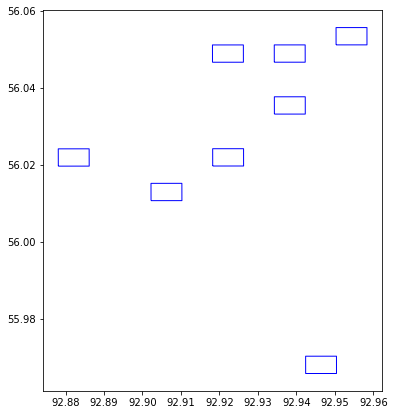

In [137]:
#ну и финал
grid_proj3d = gpd.GeoDataFrame({'geometry':transform_to_3d(familiar_areas)})
grid_proj3d.plot(color='white', edgecolor='blue', figsize = (7,7))

### Вот и всё! Экспортируем и наслаждаемся


In [138]:
with open(grid_data_dir + 'Krsk_hustle_places.json', 'w') as k:
    k.write(grid_proj3d.to_json())